# Simple GLM

In [205]:
import os
from pathlib import Path

import altair as alt
import numpy as np
import pandas as pd

from dask_ml.impute import SimpleImputer
from dask_ml.preprocessing import Categorizer
from quantcore.glm import GeneralizedLinearRegressor
from quantcore.learn.metrics import gini_score
from quantcore.learn.plotting import make_plots
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.pipeline import Pipeline

from feature_engineering import apply_all_transformations
from metrics import root_mean_squared_percentage_error
from process_data import load_test, load_train, process_data

pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option('display.max_columns', None)
alt.data_transformers.enable("json")  # to allow for large plots

DataTransformerRegistry.enable('json')

## 1. Data Loading and Feature Engineering

### 1.1 Load

In [179]:
if not all([os.path.exists(p) for p in ["raw_data/train.csv", "raw_data/test.csv", "raw_data/store.csv"]]):
    raise Exception("Please download raw data into 'raw_data' folder")

if not all([os.path.exists(p) for p in ["processed_data/train.parquet", "processed_data/test.parquet"]]):
    "Processed data not found. Processing data from raw data..."
    process_data()
    "Done"
    
df = pd.concat(
    [
        load_train().assign(sample="train"),
        load_test().assign(sample="test"),
    ],
    ignore_index=True,
).sort_values(["store", "date"])
df = df.iloc[:int(.1*len(df))]
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,sample,id
0,1,2,2013-01-01,0.000,0.000,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN
1,1,3,2013-01-02,5530.000,668.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN
2,1,4,2013-01-03,4327.000,578.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN
3,1,5,2013-01-04,4486.000,619.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN
4,1,6,2013-01-05,4997.000,635.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN


### 1.2 Feature Engineering

In [180]:
df = apply_all_transformations(df)
df.head()

/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,sample,id,age_quantile,competition_open,count,log_sales,open_lag_1,open_lag_2,open_lag_3,open_lead_1,open_lead_2,open_lead_3,promo_lag_1,promo_lag_2,promo_lag_3,promo_lead_1,promo_lead_2,promo_lead_3,school_holiday_lag_1,school_holiday_lag_2,school_holiday_lag_3,school_holiday_lead_1,school_holiday_lead_2,school_holiday_lead_3,state_holiday_lag_1,state_holiday_lag_2,state_holiday_lag_3,state_holiday_lead_1,state_holiday_lead_2,state_holiday_lead_3,store_day_of_week,store_month,store_school_holiday,store_state_holiday,store_year,zscore
0,1,2,2013-01-01,0.000,0.000,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN,-1,1.000,0,-inf,1.0,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0,0,0,0,0,0,1_2,1_1,1_1,1_True,1_2013,NaN
1,1,3,2013-01-02,5530.000,668.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN,-1,1.000,1,8.618,False,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,a,0,0,0,0,0,1_3,1_1,1_1,1_False,1_2013,NaN
2,1,4,2013-01-03,4327.000,578.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN,-1,1.000,2,8.373,True,False,1.0,True,True,False,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0,a,0,0,0,0,1_4,1_1,1_1,1_False,1_2013,NaN
3,1,5,2013-01-04,4486.000,619.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN,-1,1.000,3,8.409,True,True,False,True,False,True,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,a,0,0,0,1_5,1_1,1_1,1_False,1_2013,NaN
4,1,6,2013-01-05,4997.000,635.000,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,train,NaN,-1,1.000,4,8.517,True,True,True,False,True,True,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,0,0,0,0,1_6,1_1,1_1,1_False,1_2013,NaN


### 1.3 Validation selection

In [181]:
validation_window = [pd.to_datetime("2015-06-15"), pd.to_datetime("2015-07-31")]
select_train = (
    df["sample"].eq("train")
    & df["sales"].gt(0)
    & df["date"].lt(validation_window[0])
    & df["zscore"].abs().lt(5)
).to_numpy()

select_val = (
    df["sample"].eq("train")
    & df["sales"].gt(0)
    & df["date"].ge(validation_window[0])
    & df["date"].lt(validation_window[1])
).to_numpy()

select_test = (
    df["sample"].eq("test")
).to_numpy()


(select_train.sum(), select_val.sum())

(65996, 4446)

## 2. Fit Baseline GLM Model

In [273]:
baseline_features = ["year", "month", "day_of_week", "store"]
baseline_categorizer = Categorizer(columns=baseline_features)
baseline_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0,
    alphas=[1e-1],
)

In [347]:
baseline_glm.fit(
    baseline_categorizer.fit_transform(df[select_train][baseline_features]),
    df.loc[select_train, "log_sales"]
)

df.loc[lambda x: x["open"], "predicted_log_sales_baseline"] = baseline_glm.predict(
    baseline_categorizer.fit_transform(df.loc[lambda x: x["open"]][baseline_features])
)

df["predicted_log_sales_baseline"] = df["predicted_log_sales_baseline"].fillna(0)
df["predicted_sales_baseline"] = np.exp(df["predicted_log_sales_baseline"])

In [348]:
root_mean_squared_percentage_error(
    df.loc[select_val, "sales"], df.loc[select_val, "predicted_sales_baseline"]
)

30.817700785834255

## 3. GLM with High Dimensional Fixed Effects

In [314]:
highdim_features = [
    "age_quantile",
    "competition_open",
    "open_lag_1",
    "open_lag_2",
    "open_lag_3",
    "open_lead_1",
    "open_lead_2",
    "open_lead_3",
    "promo_lag_1",
    "promo_lag_2",
    "promo_lag_3",
    "promo_lead_1",
    "promo_lead_2",
    "promo_lead_3",
    "promo",
    "school_holiday_lag_1",
    "school_holiday_lag_2",
    "school_holiday_lag_3",
    "school_holiday_lead_1",
    "school_holiday_lead_2",
    "school_holiday_lead_3",
    "school_holiday",
    "state_holiday_lag_1",
    "state_holiday_lag_2",
    "state_holiday_lag_3",
    "state_holiday_lead_1",
    "state_holiday_lead_2",
    "state_holiday_lead_3",
    "state_holiday",
    "store_day_of_week",
    "store_month",
    "store_school_holiday",
    "store_state_holiday",
    "store_year",
]
highdim_categorizer = Pipeline([
    ("categorize", Categorizer(columns=highdim_features)),
    ("impute", SimpleImputer(strategy="most_frequent"))
])
highdim_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0, # only ridge
    #alpha=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 10],
    alpha_search=True,
)

In [315]:
highdim_glm.fit(
    highdim_categorizer.fit_transform(df[select_train][highdim_features]),
    df.loc[select_train, "log_sales"]
)

GeneralizedLinearRegressor(alpha_search=True, l1_ratio=0.0,
                           scale_predictors=True)

In [349]:
df.loc[lambda x: x["open"], "predicted_log_sales_highdim"] = highdim_glm.predict(
    highdim_categorizer.transform(df.loc[lambda x: x["open"]][highdim_features]),
)

df["predicted_log_sales_highdim"] = df["predicted_log_sales_highdim"].fillna(0)
df["predicted_sales_highdim"] = np.exp(df["predicted_log_sales_highdim"])

root_mean_squared_percentage_error(
    df.loc[select_train, "sales"], df.loc[select_train, "predicted_sales_highdim"]
)

13.450183300846492

## 4. Plot Results

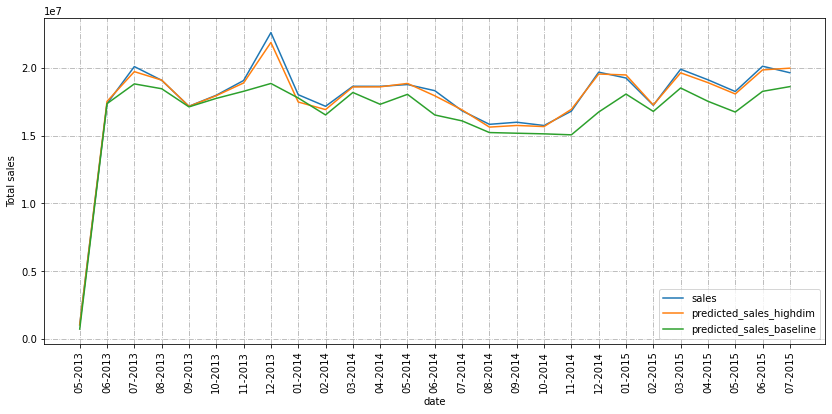

In [462]:
df_plot_date = df[select_train|select_val].groupby(
    ["year", "month"]
).agg("sum")[sales_cols].reset_index()

year_month_date = df_plot_date['month'].map(str)+ '-' + df_plot_date['year'].map(str)
df_plot_date['year_month'] = pd.to_datetime(year_month_date, format='%m-%Y').dt.strftime('%m-%Y')
df_plot_date.drop(columns= ["year", "month"], inplace=True)

_, ax = plt.subplots(1, 1, figsize=(14, 6))
df_plot_date.plot(x="year_month", ax=ax)
ax.set_xticks(range(len(df_plot_date)))
ax.set_xticklabels(df_plot_date.year_month, rotation=90)
ax.set_xlabel("date")
ax.set_ylabel("Total sales")
ax.grid(True, linestyle='-.')
plt.show()

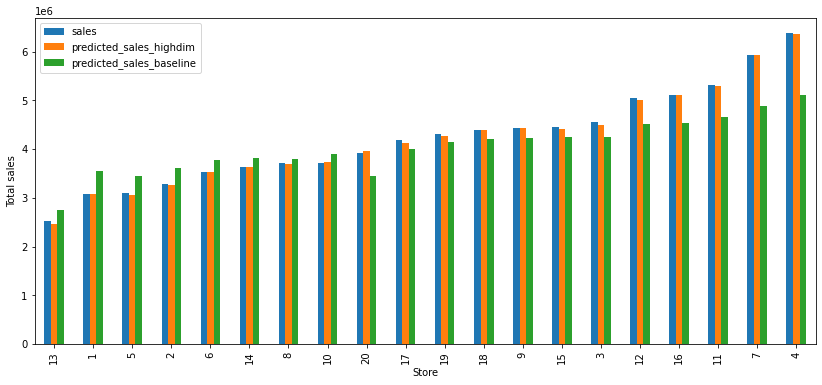

In [464]:
df_plot_store = df[select_train|select_val].groupby(
    ["store"]
).agg("sum")[sales_cols].reset_index()[:20].sort_values(by="sales")

_, ax = plt.subplots(1, 1, figsize=(14, 6))
df_plot_store.plot.bar(x="store", ax=ax)
ax.set_xlabel("Store")
ax.set_ylabel("Total sales")
plt.show()